# Credit Card Fraud Detection

This project aims to build a machine learning model to detect fraudulent credit card transactions using anonymized data. The dataset is highly imbalanced, which presents a common real-world challenge.

## Objectives:
- Perform exploratory data analysis (EDA)
- Handle class imbalance
- Train a Logistic Regression model
- Evaluate performance using relevant metrics
- Explore model improvement using SMOTE


In [46]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [47]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

# Show basic info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [48]:
# Count of each class
df['Class'].value_counts()


0    284315
1       492
Name: Class, dtype: int64

# Exploratory Data Analysis (EDA)

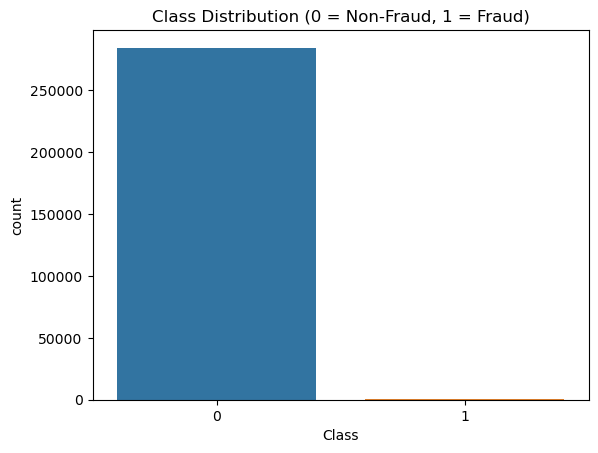

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [49]:
# Check class distribution
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Non-Fraud, 1 = Fraud)')
plt.show()

# Describe the Amount column
df['Amount'].describe()


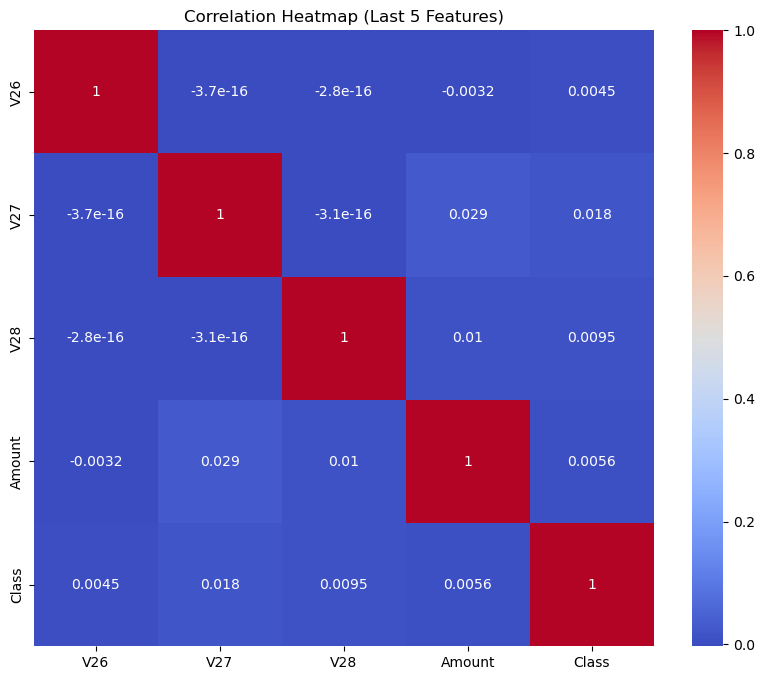

In [50]:
# Correlation heatmap (optional: only last columns to reduce clutter)
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr().iloc[-5:, -5:], annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Last 5 Features)')
plt.show()


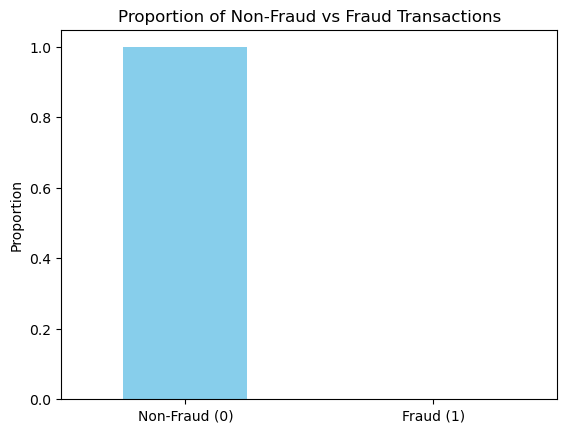

In [51]:
# Visualize proportion of classes
df['Class'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Proportion of Non-Fraud vs Fraud Transactions")
plt.xticks(ticks=[0, 1], labels=['Non-Fraud (0)', 'Fraud (1)'], rotation=0)
plt.ylabel("Proportion")
plt.show()


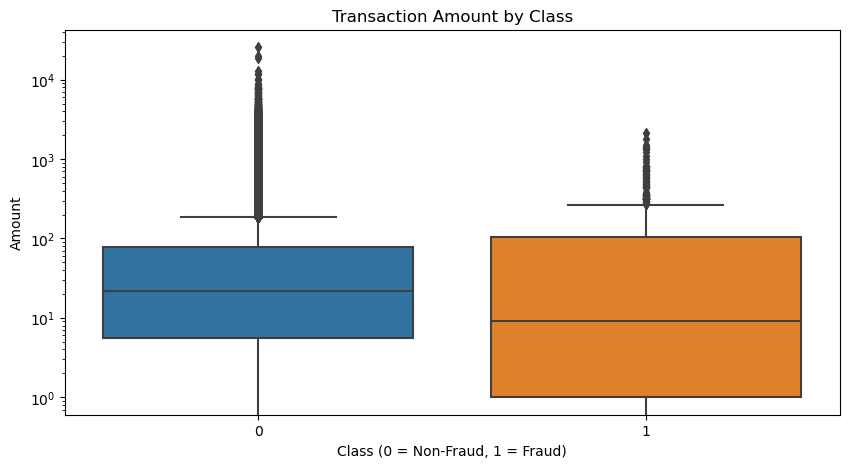

In [52]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Transaction Amount by Class")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Amount")
plt.yscale('log')  # use log scale to handle outliers
plt.show()


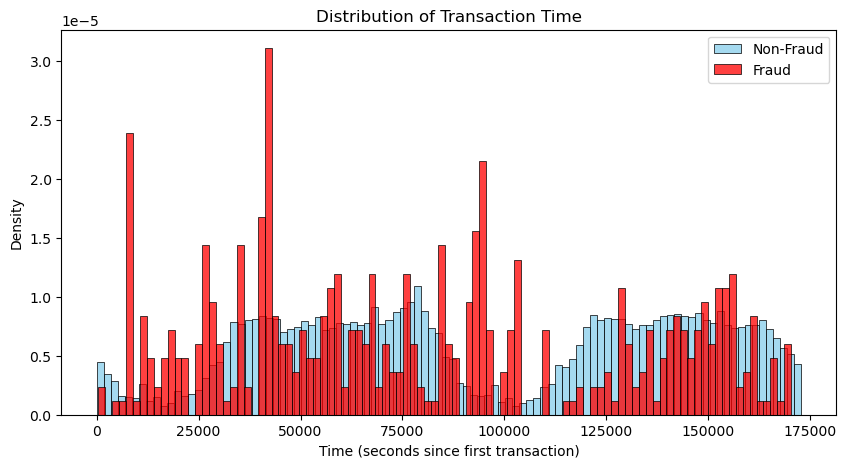

In [53]:
plt.figure(figsize=(10, 5))
sns.histplot(df[df['Class'] == 0]['Time'], bins=100, color='skyblue', label='Non-Fraud', stat='density')
sns.histplot(df[df['Class'] == 1]['Time'], bins=100, color='red', label='Fraud', stat='density')
plt.title("Distribution of Transaction Time")
plt.xlabel("Time (seconds since first transaction)")
plt.legend()
plt.show()


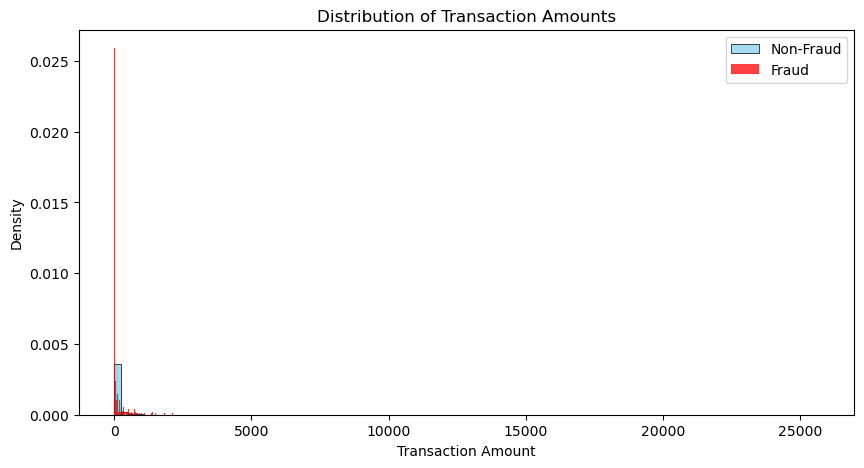

In [54]:
plt.figure(figsize=(10, 5))
sns.histplot(df[df['Class'] == 0]['Amount'], bins=100, color='skyblue', label='Non-Fraud', stat='density')
sns.histplot(df[df['Class'] == 1]['Amount'], bins=100, color='red', label='Fraud', stat='density')
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.legend()
plt.show()


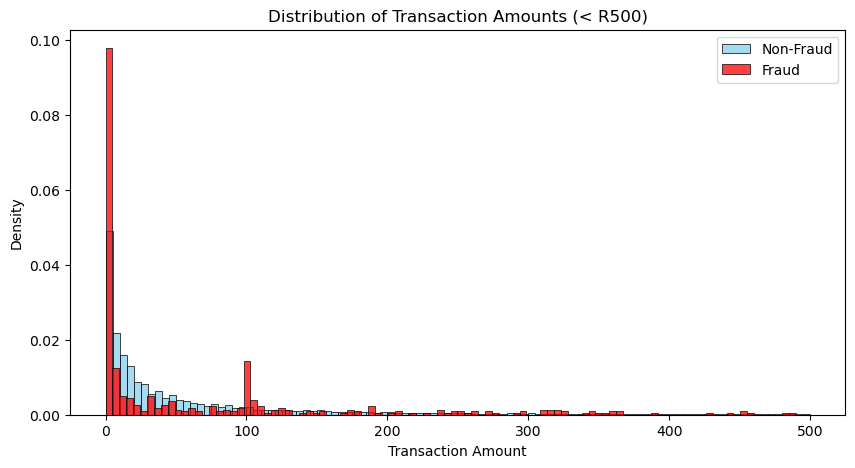

In [55]:
plt.figure(figsize=(10, 5))
subset = df[df['Amount'] < 500]  # Only look at smaller transactions
sns.histplot(subset[subset['Class'] == 0]['Amount'], bins=100, color='skyblue', label='Non-Fraud', stat='density')
sns.histplot(subset[subset['Class'] == 1]['Amount'], bins=100, color='red', label='Fraud', stat='density')
plt.title("Distribution of Transaction Amounts (< R500)")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.legend()
plt.show()


In [56]:
print("Median Fraud Amount:", df[df['Class'] == 1]['Amount'].median())
print("Median Non-Fraud Amount:", df[df['Class'] == 0]['Amount'].median())


Median Fraud Amount: 9.25
Median Non-Fraud Amount: 22.0


In [57]:
df[df['Amount'].between(95, 105) & (df['Class'] == 1)].shape


(37, 31)

In [58]:
df['log_amount'] = np.log1p(df['Amount'])  # Handles log(0)


# Preprocessing

In [59]:
# Scale 'Amount' and 'Time'
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
df['scaled_time'] = scaler.fit_transform(df[['Time']])

# Drop original columns
df.drop(['Amount', 'Time'], axis=1, inplace=True)

# Rearrange columns
scaled_df = df[['scaled_time', 'scaled_amount'] + [col for col in df.columns if col not in ['scaled_time', 'scaled_amount', 'Class']] + ['Class']]



In [60]:
# Confirm structure
scaled_df.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,log_amount,Class
0,-1.996583,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.014760,0
1,-1.996583,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,1.305626,0
2,-1.996562,1.160686,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.939276,0
3,-1.996562,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.824306,0
4,-1.996541,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.262539,0


# Train-Test Split

In [61]:
# Separate features and target
X = scaled_df.drop('Class', axis=1)
y = scaled_df['Class']

# Split the dataset (80% train, 20% test) with stratified sampling
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Confirm the shape
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (227845, 31), Test set: (56962, 31)


In [62]:

# Confirm shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (227845, 31)
X_test shape: (56962, 31)
y_train shape: (227845,)
y_test shape: (56962,)


# Baseline Model: Logistic Regression

In [63]:
# Train baseline model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


In [64]:
# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
 [[56851    13]
 [   35    63]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score: 0.9588789722416823


# ROC Curve


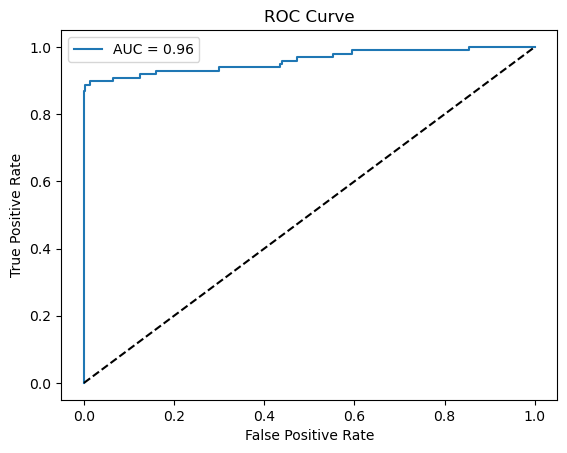

In [65]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


#  Handling Imbalance with SMOTE

In [66]:
# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Retrain model
model_smote = LogisticRegression()
model_smote.fit(X_train_sm, y_train_sm)

# Predictions
y_pred_sm = model_smote.predict(X_test)
y_proba_sm = model_smote.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report (After SMOTE):\n", classification_report(y_test, y_pred_sm))
print("ROC AUC Score (After SMOTE):", roc_auc_score(y_test, y_proba_sm))


Classification Report (After SMOTE):
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

ROC AUC Score (After SMOTE): 0.9700232671149496


# Conclusion

- The dataset is highly imbalanced with only 0.17% fraudulent transactions.
- The baseline logistic regression achieved a good AUC score, but recall was low.
- Using SMOTE significantly improved recall and overall fraud detection performance.
- This demonstrates the importance of handling imbalanced data in classification problems.
